In [1]:
import numpy as np
import pandas as pd
from numpy import linalg as nplin
import volpriceinference as vl
import matplotlib as mpl
import seaborn as sns
import logging
import tqdm
from multiprocessing import Pool

In [2]:
%matplotlib inline
mpl.style.use('seaborn-talk')
np.set_printoptions(precision=3)

In [3]:
logging.basicConfig(filename='convergence.tmp.log', level=logging.INFO)
logging.captureWarnings(True)

## Setup the True Parameters /  Simulation Parameters

In [4]:
true_params = {'equity_price': 0.50, 
               'vol_price': -7,
               'phi':-.2,
               'scale': .1,
               'delta': 1.11,
               'rho': .6,
              }
time_dim = 3000
sim_dim = 1000

## Setup the linking functions.

In [5]:
total_true_params = true_params.copy()
total_true_params.update(
    {'gamma': vl.gamma(rho=true_params['rho'], scale=true_params['scale'], delta=true_params['delta'], 
                       phi=true_params['phi'], pi=true_params['vol_price'], theta=true_params['equity_price']),
     'beta':vl.beta(rho=true_params['rho'], scale=true_params['scale'], phi=true_params['phi'], 
                    pi=true_params['vol_price'], theta=true_params['equity_price']),
     'psi':vl.psi(true_params['rho'], true_params['scale'], true_params['phi'], 
                  theta=true_params['equity_price']), 
     'phi_squared': true_params['phi']**2})

## We start by examining the distributions of simulated data

In [6]:
vl.__version__

'0.0.04-py36_3'

In [7]:
data = vl.simulate_data(time_dim=time_dim, **true_params)

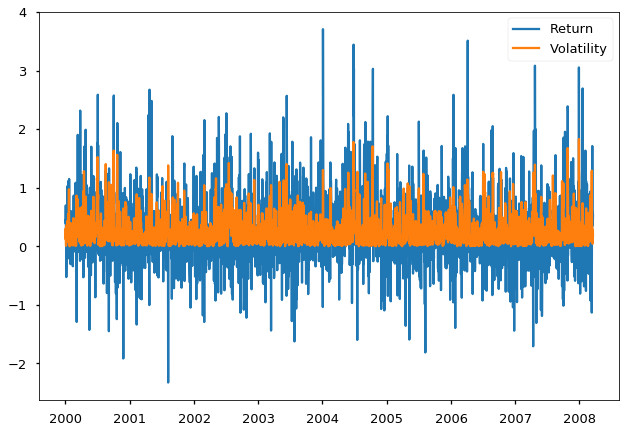

In [8]:
fig1, ax1 = mpl.pyplot.subplots()
ax1.plot(data.rtn, label='Return')
ax1.plot(data.vol, label='Volatility')
ax1.legend()


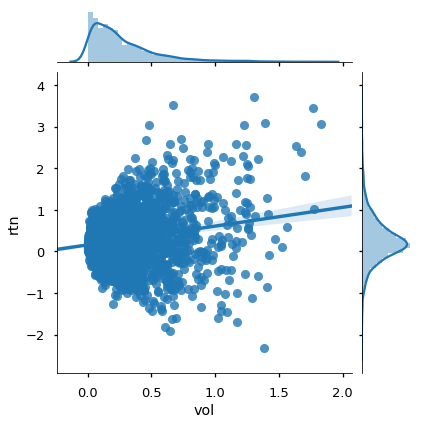

In [9]:
sns.jointplot(x='vol', y='rtn', data=data, kind='reg')

In [10]:
data.describe()

,vol,rtn
count,3000.000000,3000.000000
mean,0.273079,0.280165
std,0.260493,0.570882
min,0.000106,-2.325557
25%,0.086965,-0.026654
50%,0.198002,0.222744
75%,0.373062,0.550295
max,1.830790,3.706192


## The Asymptotic Distributions in the Strongly Identified Case

In [11]:
def gen_data(x):
    return vl.simulate_data(time_dim=time_dim, **true_params) 

In [12]:
# with Pool(8) as pool:
data_arr = list(map(gen_data, tqdm.tnrange(sim_dim)))

In [13]:
with Pool(8) as pool:
    est_arr = list(tqdm.tqdm_notebook(pool.imap_unordered(vl.estimate_params, data_arr), total=len(data_arr)))

Text(0.5,0,'delta')

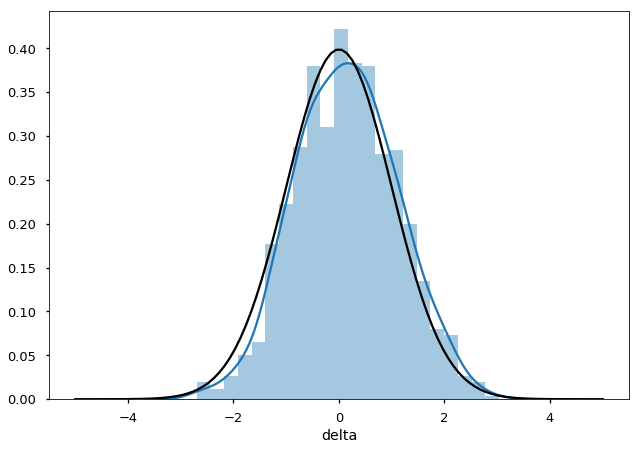

In [14]:
delta_fig, delta_ax = mpl.pyplot.subplots()
sns.distplot([(est['delta'] - true_params['delta']) / np.sqrt(cov.loc['delta','delta']) 
              for est, cov in est_arr], ax=delta_ax)
delta_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
delta_ax.set_xlabel('delta')

Text(0.5,0,'scale')

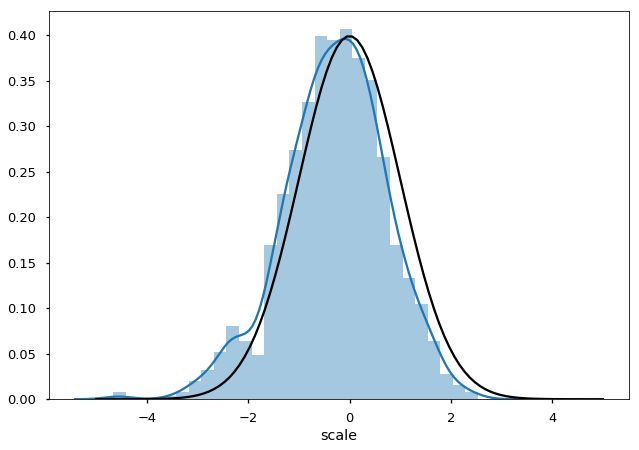

In [15]:
scale_fig, scale_ax = mpl.pyplot.subplots()
sns.distplot([(est['scale'] - true_params['scale']) / np.sqrt(cov.loc['scale', 'scale']) 
              for est, cov in est_arr], ax=scale_ax)
scale_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
scale_ax.set_xlabel('scale')

Text(0.5,0,'rho')

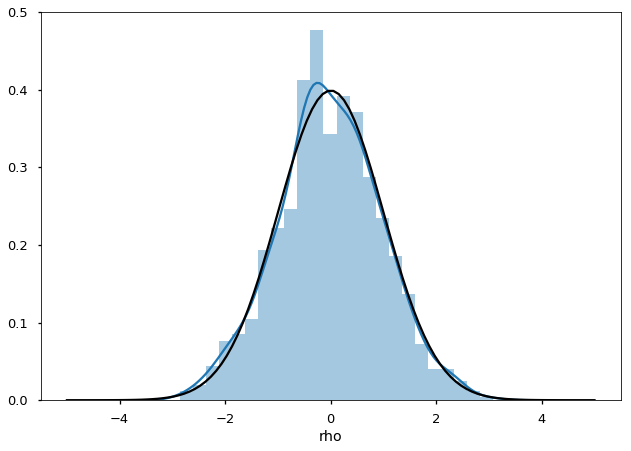

In [16]:
rho_fig, rho_ax = mpl.pyplot.subplots()
sns.distplot([(est['rho'] - true_params['rho']) / np.sqrt(cov.loc['rho', 'rho']) 
              for est, cov in est_arr], ax=rho_ax)
rho_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
rho_ax.set_xlabel('rho')

Text(0.5,0,'equity price')

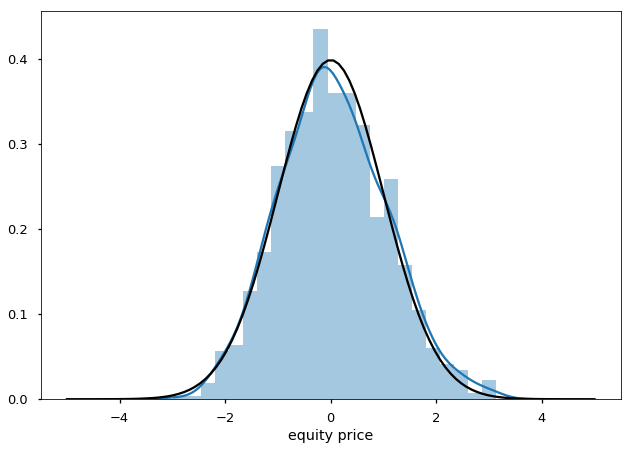

In [17]:
equity_price_fix, equity_price_ax = mpl.pyplot.subplots()
sns.distplot([(est['equity_price'] - true_params['equity_price']) / 
              np.sqrt(cov.loc['equity_price', 'equity_price']) for est, cov in est_arr], ax=equity_price_ax)
equity_price_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
equity_price_ax.set_xlabel('equity price')

Text(0.5,0,'vol_price')

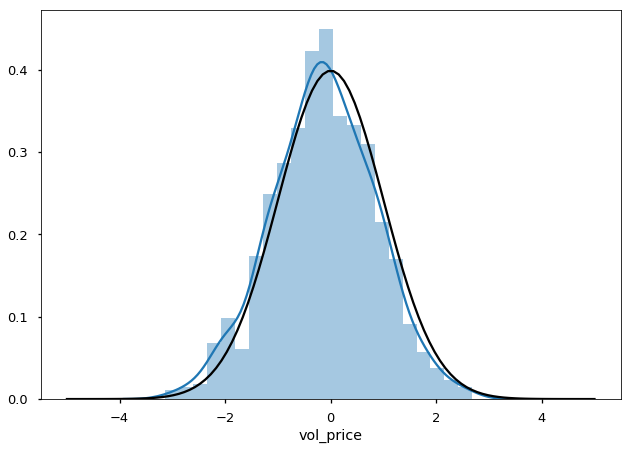

In [18]:
vol_price_fix, vol_price_ax = mpl.pyplot.subplots()
sns.distplot([(est['vol_price'] - true_params['vol_price']) / 
              np.sqrt(cov.loc['vol_price', 'vol_price']) for est, cov in est_arr], ax=vol_price_ax)
vol_price_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
vol_price_ax.set_xlabel('vol_price')

(-10, 10)

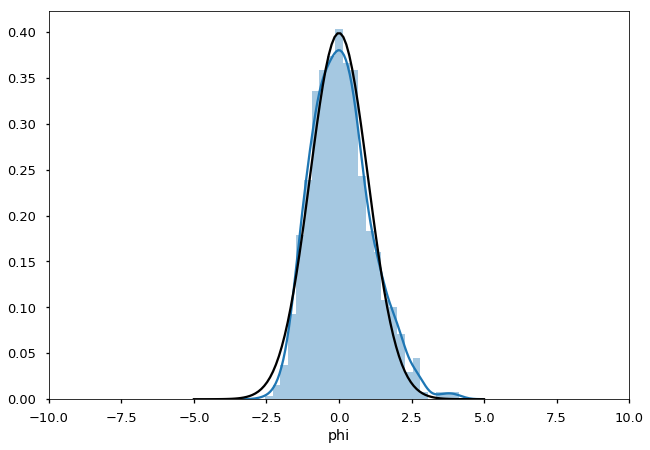

In [19]:
phi_fig, phi_ax = mpl.pyplot.subplots()
sns.distplot([(est['phi'] - true_params['phi']) / np.sqrt(cov.loc['phi', 'phi'])
              for est, cov in est_arr], ax=phi_ax)
phi_ax.plot(np.linspace(-5,5,100), stats.norm.pdf(np.linspace(-5,5,100)), color='black')
phi_ax.set_xlabel('phi')
phi_ax.set_xlim([-10,10])

In [20]:
import sympy as sym

In [21]:
from volpriceinference.volprice import beta_sym, gamma_sym

In [22]:
sym.init_printing()

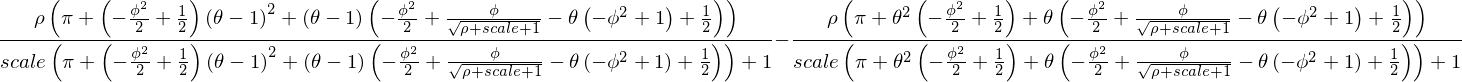

In [23]:
beta_sym

In [24]:
delta, phi, pi, psi, rho, scale, theta, x = sym.symbols('delta phi psi, pi rho scale theta x')

In [25]:
true_params

{'equity_price': 0.5,
 'vol_price': -7,
 'phi': -0.2,
 'scale': 0.1,
 'delta': 1.11,
 'rho': 0.6}

In [26]:
link_pi_sym = sym.Matrix([beta_sym, gamma_sym]).replace(theta, (1 - phi**2)**(-1) * (psi - (phi / sym.sqrt(1 + rho) + ( 1 - phi**2)/2)))

In [27]:
link_pi_in = sym.lambdify((delta, phi, pi, psi, rho, scale), link_pi_sym)

In [28]:
def link_pi(omega, pi):
    
    return np.squeeze(link_pi_in(delta=omega['delta'], phi=omega['phi'], psi=omega['psi'], rho=omega['rho'], scale=omega['scale'], pi=pi))

In [29]:
link_pi_grad_in = sym.lambdify((delta, phi, pi, psi, rho, scale), link_pi_sym.jacobian((delta, phi, psi, rho, scale)))

In [30]:
def covariance_kernel(omega, vol_price1, vol_price2, reduced_form_cov):
    """ This function computes the covariance kernel """
    
    left_bread = link_pi_grad_in(delta=omega['delta'], phi=omega['phi'], pi=vol_price1, psi=omega['psi'], rho=omega['rho'], scale=omega['scale']).T
    right_bread = link_pi_grad_in(delta=omega['delta'], phi=omega['phi'], pi=vol_price2, psi=omega['psi'], rho=omega['rho'], scale=omega['scale']).T
    
    return np.squeeze(left_bread.T @ reduced_form_cov @ right_bread)

In [31]:
reduced_est, reduced_cov = vl.compute_step2(data)

In [32]:
vol_est, vol_cov = vl.compute_vol_gmm(data.vol, init_constants=vl.compute_init_constants(data.vol))

In [185]:
def compute_omega(vol_cov, reduced_cov, params):
    reduced_cov2 = pd.merge(vol_cov, reduced_cov, how='outer', left_index=True, right_index=True).fillna(0).rename(
        columns={'phi_squared':'phi'}).rename({'phi_squared':'phi'}).sort_index(axis=0).sort_index(axis=1)
    reduced_cov2['phi'] *= 2 * abs(params['psi'])
    omega_cov = reduced_cov2.loc[['delta', 'phi',  'psi', 'rho', 'scale'], ['delta', 'phi',  'psi', 'rho', 'scale']]
    
    return omega_cov

In [186]:
compute_omega(vol_cov, reduced_cov, true_params)

,delta,phi,psi,rho,scale
delta,0.002252,0.000000,0.000000,-0.000460,-0.000104
phi,0.000000,0.379159,0.000000,0.000000,0.000000
psi,0.000000,0.000000,0.001872,0.000000,0.000000
rho,-0.000460,0.000000,0.000000,0.000380,-0.000014
scale,-0.000104,0.000000,0.000000,-0.000014,0.000017


In [35]:
true_params.update({'psi':reduced_est['psi']})

In [36]:
reduced_est['psi']

In [37]:
def projection_residual_process(omega, vol_price, vol_price_true, reduced_form_cov):
    
    link1 = link_pi(omega=omega, vol_price=vol_price) 
    link2 = link_pi(omega=omega, vol_price=vol_price_true) 
    
    cov1 = covariance_kernel(omega=omega, vol_price1=vol_price, vol_price2=vol_price_true, reduced_form_cov=reduced_form_cov)
    cov2 = covariance_kernel(omega=omega, vol_price1=vol_price_true, vol_price2=vol_price_true, reduced_form_cov=reduced_form_cov)
    
    
    return np.squeeze(link1 - cov1 @ np.linalg.solve(cov2, link2))

In [38]:
from scipy import optimize

In [39]:
def qlr_stat(omega, vol_price_true, reduced_form_cov, time_dim):
    
    cov_true_true = covariance_kernel(omega=omega, vol_price1=vol_price_true, vol_price2=vol_price_true, reduced_form_cov=reduced_form_cov)
    
    def qlr_in(pi):
        link_pi_in = link_pi(omega, pi=pi)
        cov_pi = covariance_kernel(omega=omega, vol_price1=pi, vol_price2=pi, reduced_form_cov=reduced_form_cov)
        
        return np.asscalar(time_dim * link_pi_in.T @ np.linalg.solve(cov_pi, link_pi_in))
    
    result = optimize.minimize(lambda x: qlr_in(x), x0=vol_price_true, method="SLSQP", bounds=[(-20, 0)])

    return qlr_in(vol_price_true) - result.fun

In [40]:
def qlr_sim(omega, vol_price_true, reduced_form_cov, time_dim):
    
    cov_true_true = covariance_kernel(omega=omega, vol_price1=vol_price_true, vol_price2=vol_price_true, reduced_form_cov=reduced_form_cov)
    
#     # We start by simulating v_{moment_conds}
    upsilon_star = stats.multivariate_normal.rvs(mean=np.zeros(2), cov=cov_true_true)
    
    def link_star(pi):
        link_pi_in = link_pi(omega=omega, pi=pi)
        cov_pi_true =  covariance_kernel(omega=omega, vol_price1=pi, vol_price2=vol_price_true, reduced_form_cov=reduced_form_cov)
        
        # We combine computing h(pi, omega) and g_star into one step.
        link_star_in = link_pi_in - cov_pi_true @ np.linalg.solve(cov_true_true, link_pi(omega=omega, pi=vol_price_true)-upsilon_star)
        
        return link_star_in
    
    def qlr_in_star(pi):
        link_pi_in = link_star(pi=pi)
        cov_pi_pi = covariance_kernel(omega=omega, vol_price1=pi, vol_price2=pi, reduced_form_cov=reduced_form_cov)
        
        return np.asscalar(time_dim * link_pi_in.T @ np.linalg.solve(cov_pi_pi, link_pi_in))   
    
    result = optimize.minimize(lambda x: qlr_in_star(x), x0=vol_price_true, method="SLSQP", bounds=[(-20, 0)])
    
    return qlr_in_star(vol_price_true) - result.fun
    

In [41]:
qlr_sim(omega=true_params, vol_price_true=-7, reduced_form_cov=omega_cov, time_dim=time_dim)

In [42]:
qlr_draws = [qlr_sim(omega=true_params, vol_price_true=-7, reduced_form_cov=omega_cov, time_dim=data.shape[0]) for _ in tqdm.tqdm_notebook(range(100))]

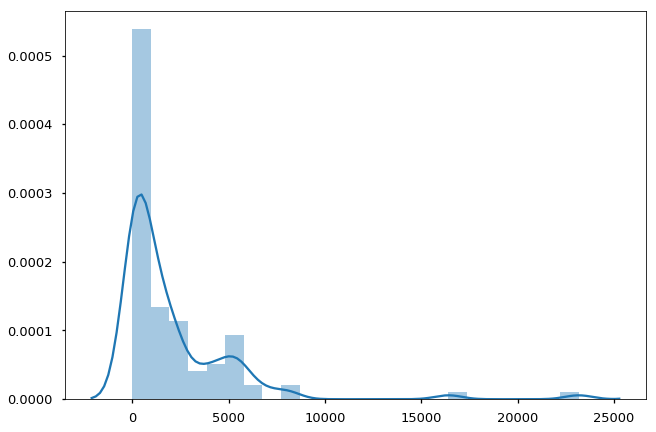

In [43]:
sns.distplot(qlr_draws)

In [235]:
qlr_stats = pd.DataFrame([(x, qlr_stat(omega=true_params,vol_price_true=x,reduced_form_cov=omega_cov, time_dim=data.shape[0])) for x in np.linspace(-20, 0, 50)],
                        columns=[0, 'stats']).set_index(0)

In [184]:
qlr_draws = pd.DataFrame([([val] + [qlr_sim(omega=true_params, vol_price_true=val, reduced_form_cov=omega_cov, time_dim=data.shape[0])
                                   for _ in tqdm.tqdm_notebook(range(500), leave=False)])
                         for val in np.linspace(-20, 0, 50)])

In [198]:
qlr_percentiles = pd.DataFrame([(name, val[0], val[1]) for name, val in qlr_draws.set_index(0).agg(
    np.percentile, axis=1, q=[5, 95]).items()]).rename(columns={1:'five',2:'ninety5'})

In [201]:
accepted_vals = pd.Series(pd.merge(qlr_percentiles, qlr_stats, left_on=0, right_on=0).set_index(0).query('five < stats and ninety5 > stats').index)


In [331]:
ci_values = pd.concat([pd.Series(qlr_percentiles.set_index(0).query('five < @row').query('ninety5 > @row').index, name=name).to_frame().unstack().reset_index(
    level=0).rename(columns={'level_0':'pi0', 0:'ci'})
          for name, row in qlr_stats.itertuples()])

In [375]:
min_max_values = ci_values.groupby('pi0').aggregate([np.min, np.mean, np.max]).T.reset_index(0, drop=True).T

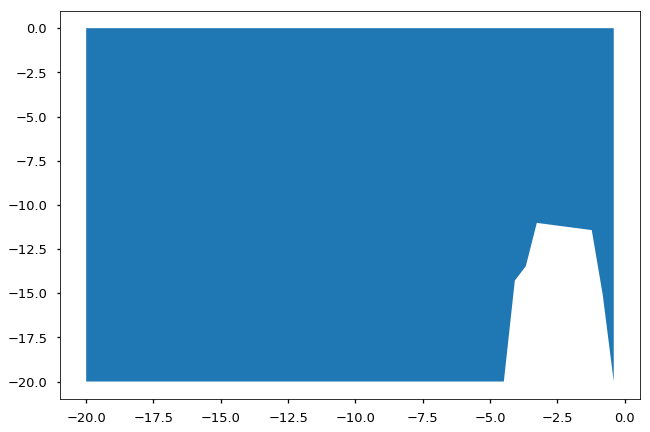

In [378]:
fig2, ax2 = mpl.pyplot.subplots()
# ax2.scatter()
ax2.fill_between(min_max_values.index, min_max_values.amin, min_max_values.amax)

In [389]:
from matplotlib import ticker as mticker

array([-20.   , -18.367, -16.735, -15.102, -13.469, -11.837, -10.204,
        -8.571,  -6.939,  -5.306,  -3.673,  -2.041,  -0.408])

In [454]:
np.unique(ci_values.query('pi0<-18').pi0)[::2]

array([-20.   , -19.184, -18.367])

In [501]:
from itertools import islice

In [502]:
ax3.xaxis.get_ticklocs()

array([0, 4])

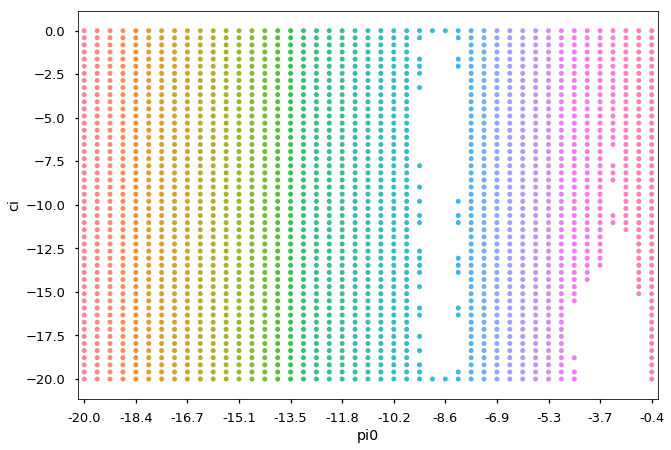

In [513]:
fig3, ax3 = mpl.pyplot.subplots()
sns.swarmplot(x='pi0', y='ci', data=ci_values, ax=ax3)
labels_old = ax3.xaxis.get_ticklabels().copy()
ax3.xaxis.set_major_locator(mticker.FixedLocator(ax3.xaxis.get_ticklocs()[::4]))
ax3.xaxis.set_ticklabels(labels_old[::4])
ax3.xaxis.set_major_formatter(mticker.FixedFormatter(["{:.01f}".format(float(val.get_text())) for val in ax3.xaxis.get_ticklabels()]))